In [17]:
!pip install kagglehub[pandas-datasets]

Dataset downloaded to: /kaggle/input/cell-images-for-detecting-malaria
Parasitized samples: 13779
Uninfected samples: 13779


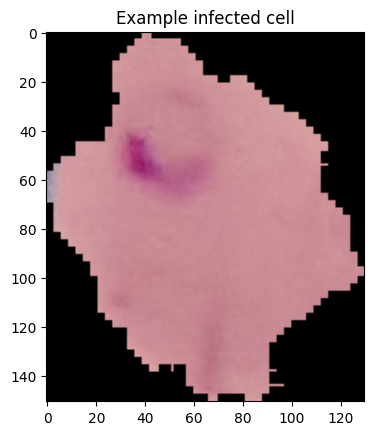

In [18]:
# pip install kagglehub
import kagglehub
import os

# Download the dataset (latest version)
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Dataset downloaded to:", path)

# Now you can explore images in the folder
# Example: count files or preview some
import glob

infected_images = glob.glob(os.path.join(path, "cell_images/Parasitized/*.png"))
uninfected_images = glob.glob(os.path.join(path, "cell_images/Uninfected/*.png"))

print("Parasitized samples:", len(infected_images))
print("Uninfected samples:", len(uninfected_images))

# Example: view one image with matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(infected_images[0])
plt.imshow(img)
plt.title("Example infected cell")
plt.show()


In [19]:
import pandas as pd
import sys

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    accuracy_score, 
    confusion_matrix
)
from PIL import Image

In [20]:
# Label them and combine
infected = [(path, 1) for path in infected_images]
uninfected = [(path, 0) for path in uninfected_images]
all_data = infected + uninfected

# Split into train (80%) and a temporary set (20%)
train_data, temp_data = train_test_split(all_data, test_size=0.2, random_state=42, shuffle=True)

# Split the temporary set (20% of total) into validation (10% of total) and test (10% of total)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Train samples: 22046
Validation samples: 2756
Test samples: 2756


In [21]:
class MalariaDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [22]:
train_transform = transforms.Compose(
    [
      # For Exercise 2 - Add image transforms here before ToTensor()
      transforms.Resize((128, 128)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomRotation(45),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
      transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.01, 2.0)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = MalariaDataset(train_data, transform=train_transform)
val_dataset = MalariaDataset(val_data, transform=test_transform)
test_dataset = MalariaDataset(test_data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

class_labels = {0: "Uninfected", 1: "Infected"}
classes = ("Uninfected", "Infected")

print("Batches in train:", len(train_loader))
print("Batches in validation:", len(val_loader))

Batches in train: 87
Batches in validation: 11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Uninfected Infected Infected Infected Uninfected Uninfected Infected Uninfected


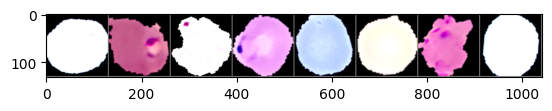

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]))

# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(8)))

In [24]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
def train_epoch(model, dataloader, device, optimizer, criterion, epoch):
    # We set the model to be in training mode
    model.train()

    total_train_loss = 0.0
    total_correct = 0
    dataset_size = 0

    # Lists to store batch-level metrics
    batch_losses = []
    batch_accuracies = []

    # This is only for showing the progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)

    # We iterate through all batches - 1 step is 1 batch of batch_size images
    for step, (images, labels) in bar:
        # We take the images and their labels and push them on GPU
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        # Reset gradients
        optimizer.zero_grad()

        # Obtain predictions
        pred = model(images)

        # Compute loss for this batch
        loss = criterion(pred, labels)

        # Compute gradients for each weight (backpropagation)
        loss.backward()

        # Update weights based on gradients (gradient descent)
        optimizer.step()

        # --- Metrics Calculation ---
        batch_loss = loss.item()
        total_train_loss += (batch_loss * batch_size)
        
        _, predicted = torch.max(pred, 1)
        batch_correct = (predicted == labels).sum().item()
        total_correct += batch_correct
        
        dataset_size += batch_size
        
        # Store batch-level metrics
        batch_acc = batch_correct / batch_size
        batch_losses.append(batch_loss)
        batch_accuracies.append(batch_acc)

        # Update progress bar with running epoch averages
        epoch_loss = np.round(total_train_loss / dataset_size, 4)
        epoch_acc = np.round(total_correct / dataset_size, 4)
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Acc=epoch_acc)
    
    # Calculate final epoch averages
    avg_epoch_loss = total_train_loss / dataset_size
    avg_epoch_acc = total_correct / dataset_size
    
    return avg_epoch_loss, avg_epoch_acc, batch_losses, batch_accuracies

In [26]:
def valid_epoch(model, dataloader, device, criterion, epoch, name="Valid", comprehensive=False):
    model.eval()

    total_val_loss = 0.0
    dataset_size = 0
    correct = 0

    # Lists for batch-level metrics (for validation plots)
    batch_losses = []
    batch_accuracies = []
    
    # Lists for comprehensive metrics (for final test)
    all_labels = []
    all_preds = []
    all_probs = []

    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)

    with torch.no_grad():
        for step, (images, labels) in bar:
            images = images.to(device)
            labels_batch = labels.to(device)
            batch_size = images.shape[0]

            pred_logits = model(images)
            loss = criterion(pred_logits, labels_batch)

            # --- Metrics Calculation ---
            batch_loss = loss.item()
            _, predicted_class = torch.max(pred_logits, 1)
            batch_correct = (predicted_class == labels_batch).sum().item()
            batch_acc = batch_correct / batch_size
            
            # Store batch-level metrics
            batch_losses.append(batch_loss)
            batch_accuracies.append(batch_acc)
            
            # Accumulate for epoch averages
            correct += batch_correct
            total_val_loss += (batch_loss * batch_size)
            dataset_size += batch_size

            # For comprehensive, store all labels, preds, and probs
            if comprehensive:
                probabilities = F.softmax(pred_logits, dim=1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted_class.cpu().numpy())
                all_probs.extend(probabilities[:, 1].cpu().numpy()) # Prob of class 1

            # Update progress bar
            epoch_loss_rounded = np.round(total_val_loss / dataset_size, 4)
            accuracy_rounded = np.round(100 * correct / dataset_size, 4)
            postfix_dict = {'Epoch': epoch, f'{name}_Acc': accuracy_rounded, f'{name}_Loss': epoch_loss_rounded}
            bar.set_postfix(**postfix_dict)

    avg_epoch_loss = total_val_loss / dataset_size
    avg_epoch_acc = correct / dataset_size

    # --- Return logic ---
    if comprehensive:
        # Calculate all metrics at the end
        metrics = {
            'Accuracy': accuracy_score(all_labels, all_preds),
            'Precision': precision_score(all_labels, all_preds),
            'Recall': recall_score(all_labels, all_preds),
            'F1-Score': f1_score(all_labels, all_preds),
            'ROC-AUC': roc_auc_score(all_labels, all_probs),
            'Loss': avg_epoch_loss,
            'ConfusionMatrix': confusion_matrix(all_labels, all_preds)
        }
        return metrics # Return the dictionary
    else:
        # Return epoch averages AND batch lists for validation plotting
        return avg_epoch_acc, avg_epoch_loss, batch_losses, batch_accuracies

In [27]:
def run_training(model, criterion, optimizer, scheduler, num_epochs):
    # Check if we are using GPU
    if torch.cuda.is_available():
        print(f"[INFO] Using GPU: {torch.cuda.get_device_name()}\n")

    # For keeping track of the best validation accuracy
    top_accuracy = 0.0

    # History tracking for all metrics
    history = {
        'epoch_train_loss': [],
        'epoch_train_acc': [],
        'epoch_val_loss': [],
        'epoch_val_acc': [],
        'batch_train_loss': [],   # All train batches, appended
        'batch_train_acc': [],    # All train batches, appended
        'batch_val_loss': [],     # All validation batches, appended
        'batch_val_acc': [],      # All validation batches, appended
        'final_test_metrics': {}  # For the final results dictionary
    }

    # We train the model for a number of epochs
    for epoch in range(num_epochs):

        # --- Training ---
        train_loss, train_acc, b_losses, b_accs = train_epoch(
            model, train_loader, device, optimizer, criterion, epoch
        )
        history['epoch_train_loss'].append(train_loss)
        history['epoch_train_acc'].append(train_acc)
        history['batch_train_loss'].extend(b_losses) 
        history['batch_train_acc'].extend(b_accs)
        

        # --- Validation ---
        with torch.no_grad():
            # Call with comprehensive=False (default)
            val_acc, val_loss, b_val_losses, b_val_accs = valid_epoch(
                model, val_loader, device, criterion, epoch, name="Valid"
            )
            history['epoch_val_loss'].append(val_loss)
            history['epoch_val_acc'].append(val_acc)
            history['batch_val_loss'].extend(b_val_losses) # Add batch metrics
            history['batch_val_acc'].extend(b_val_accs)   # Add batch metrics
        
        # --- Scheduler & Model Checkpointing ---
        scheduler.step(val_loss)
        print(f"Current LR: {scheduler.get_last_lr()}")
        
        if val_acc > top_accuracy:
            print(f"Validation Accuracy Improved ({top_accuracy:.4f} ---> {val_acc:.4f})")
            top_accuracy = val_acc
        print()
        
    # --- Final Test ---
    print("Training Complete. Running Comprehensive Test on Test Set...")
    with torch.no_grad():
        # Call with comprehensive=True
        test_metrics = valid_epoch(
            model, test_loader, device, criterion, epoch="Test", name="Test", comprehensive=True
        )
    
    # Store comprehensive metrics in history
    history['final_test_metrics'] = test_metrics

    # --- Display Results Table ---
    print("\n--- Final Test Metrics ---")
    
    # Create a DataFrame for nice printing (the table)
    # We need to pop the confusion matrix because it's an array, not a single number
    cm = test_metrics.pop('ConfusionMatrix') 
    
    metrics_df = pd.DataFrame(test_metrics, index=['Score']).T
    
    # Format the table
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(metrics_df)
    
    print("\nTest Confusion Matrix:")
    print(cm)
    print(f"(Rows: True Labels, Cols: Predicted Labels)")
    
    return history

In [28]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [29]:
class CNN_MALARIA(nn.Module):

    def __init__(self, params):

        super(CNN_MALARIA, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

        self.activation = nn.GELU()

    def forward(self,X):

        X = self.activation(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = self.activation(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.activation(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.activation(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = self.activation(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return X

In [30]:
params_model={
        "shape_in": (3,128,128),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}


model = CNN_MALARIA(params_model)
model.to(device)

CNN_MALARIA(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (activation): GELU(approximate='none')
)

In [31]:
# Hyperparameters
learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss() # this parameter relaxes the confidence requirement

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

from torch.optim.lr_scheduler import ReduceLROnPlateau

# used for lowering the learning rate with * @factor after @patience epochs
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.1,
                              patience=2)

In [32]:
history = run_training(model, criterion, optimizer, scheduler, epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 11/11 [00:05<00:00,  1.91it/s, Epoch=0, Valid_Acc=93.9, Valid_Loss=0.173]
Current LR: [0.001]
Validation Accuracy Improved (0.0000 ---> 0.9390)

100%|██████████| 11/11 [00:05<00:00,  1.95it/s, Epoch=1, Valid_Acc=95.4, Valid_Loss=0.14] 
Current LR: [0.001]
Validation Accuracy Improved (0.9390 ---> 0.9536)

100%|██████████| 11/11 [00:05<00:00,  1.85it/s, Epoch=2, Valid_Acc=95.8, Valid_Loss=0.145]
Current LR: [0.001]
Validation Accuracy Improved (0.9536 ---> 0.9579)

100%|██████████| 11/11 [00:05<00:00,  2.00it/s, Epoch=3, Valid_Acc=95.9, Valid_Loss=0.135]
Current LR: [0.001]
Validation Accuracy Improved (0.9579 ---> 0.9590)

100%|██████████| 11/11 [00:05<00:00,  2.03it/s, Epoch=4, Valid_Acc=95.7, Valid_Loss=0.136]
Current LR: [0.001]

100%|██████████| 11/11 [00:05<00:00,  1.95it/s, Epoch=5, Valid_Acc=95.9, Valid_Loss=0.13] 
Current LR: [0.001]

100%|██████████| 11/11 [00:05<00:00,  1.90it/s, Epoch=6, Valid_Acc=95.9, Valid_Loss=0.128]
Current L

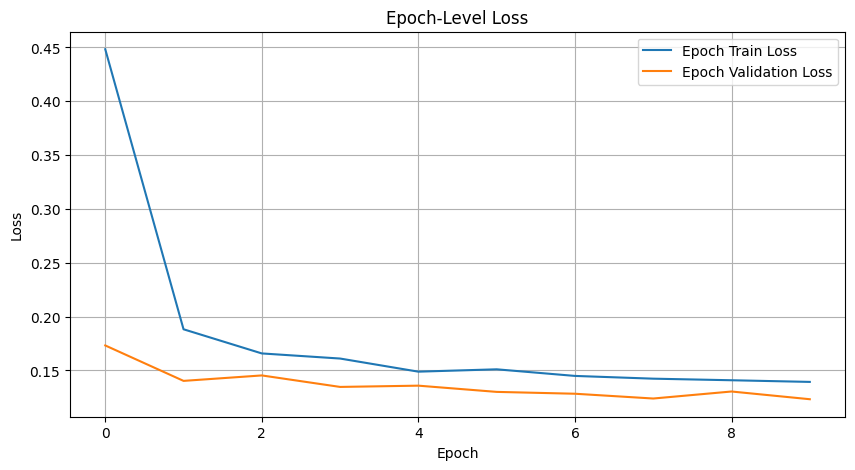

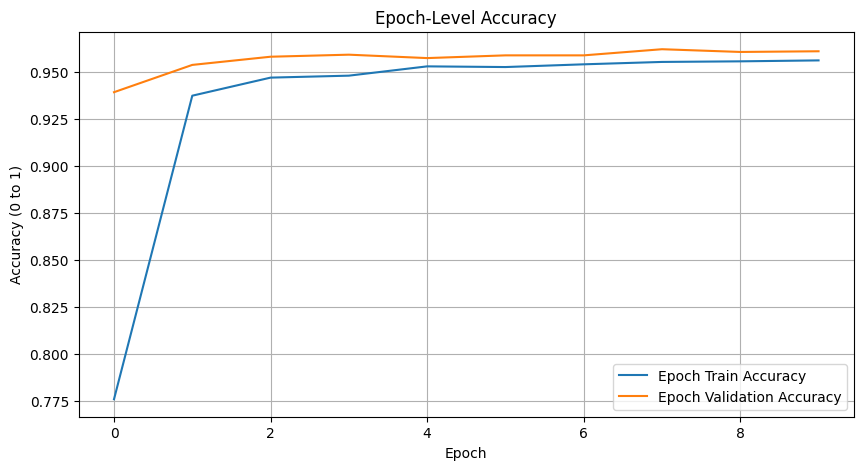

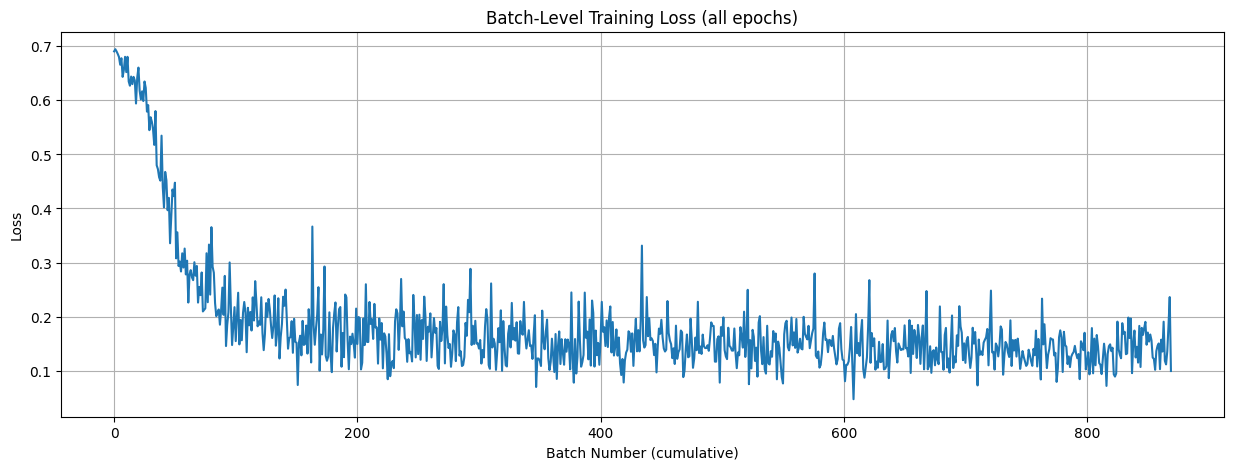

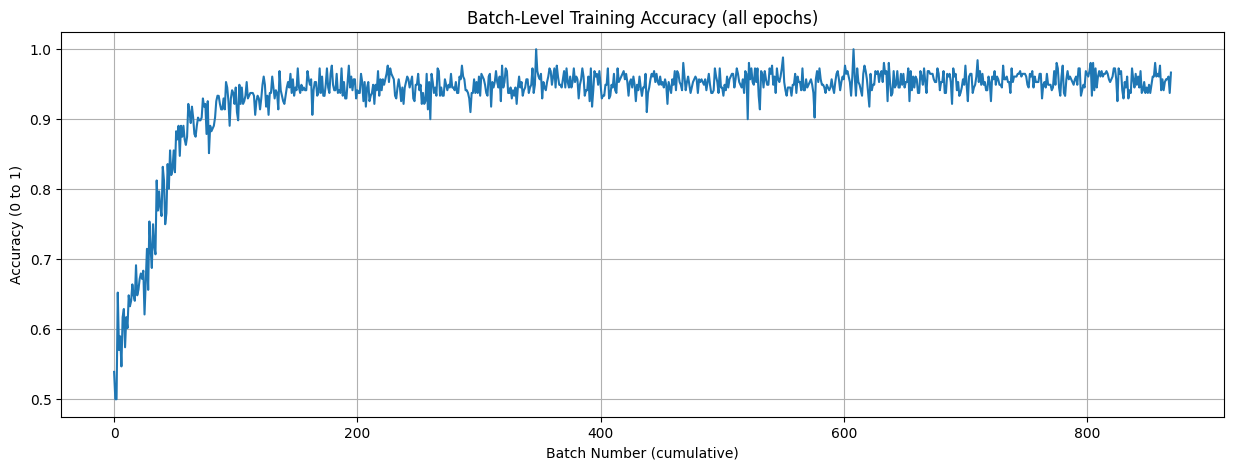

In [33]:
import matplotlib.pyplot as plt

# --- Plot 1: Epoch Loss (Train vs. Validation) ---
plt.figure(figsize=(10, 5))
plt.plot(history['epoch_train_loss'], label='Epoch Train Loss')
plt.plot(history['epoch_val_loss'], label='Epoch Validation Loss')
plt.title('Epoch-Level Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: Epoch Accuracy (Train vs. Validation) ---
plt.figure(figsize=(10, 5))
plt.plot(history['epoch_train_acc'], label='Epoch Train Accuracy')
plt.plot(history['epoch_val_acc'], label='Epoch Validation Accuracy')
plt.title('Epoch-Level Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (0 to 1)')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 3: Batch-Level Training Loss ---
# This will be a noisy plot, but it shows learning dynamics
plt.figure(figsize=(15, 5))
plt.plot(history['batch_train_loss'])
plt.title('Batch-Level Training Loss (all epochs)')
plt.xlabel('Batch Number (cumulative)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# --- Plot 4: Batch-Level Training Accuracy ---
plt.figure(figsize=(15, 5))
plt.plot(history['batch_train_acc'])
plt.title('Batch-Level Training Accuracy (all epochs)')
plt.xlabel('Batch Number (cumulative)')
plt.ylabel('Accuracy (0 to 1)')
plt.grid(True)
plt.show()

In [34]:
# Save the full model
torch.save(model, "cnn_malaria_full.pth")

In [35]:
# Load the model from memory
model_loaded = torch.load("cnn_malaria_full.pth", weights_only=False)